In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_alarm_heatmap(
    csv_filename,
    lowest_percentage,
    highest_percentage,
    step_percent,
    debug,
    detector_interval,   # e.g., 30 for ±30%
    atm_interval         # e.g., 10 for ±10%
):
    # Define colors for each case
    COLOR_LIGHT_GREEN = (0.0, 1.0, 0.0)
    COLOR_LIGHT_ORANGE = (1.0, 0.85, 0.5)
    COLOR_DARK_ORANGE = (1.0, 0.55, 0.0)
    COLOR_RED = (1.0, 0.2, 0.2)
    COLOR_DARK_GREEN = (0.0, 0.3, 0.0)
    COLOR_DARKER_GREEN = (0.0, 0.15, 0.0)

    # Read the CSV file
    df = pd.read_csv(csv_filename)

    # Create a pivot table for the heatmap with swapped axes
    pivot_data = df.pivot_table(
        index='gbf_T(s)',      # y-axis
        columns='clk_s_T(s)',  # x-axis
        values='Alarm_Detector',   # placeholder
        aggfunc='first'
    )

    # Create a color matrix
    color_matrix = np.zeros((len(pivot_data.index), len(pivot_data.columns), 3))

    # Prepare value lists for interval checks
    x_values = list(pivot_data.columns)
    y_values = list(pivot_data.index)

    if debug:
        print(-lowest_percentage - detector_interval)
        print(-lowest_percentage - atm_interval)
        print(highest_percentage - detector_interval)
        print(highest_percentage - atm_interval)

    for i, gbf_T in enumerate(y_values):      # y-axis
        for j, clk_T in enumerate(x_values):  # x-axis
            # Find the matching row
            match = df[(df['clk_s_T(s)'] == clk_T) & (df['gbf_T(s)'] == gbf_T)]
            if match.empty:
                # Fill with black if missing
                color_matrix[i, j] = [0, 0, 0]
                continue
            row = match.iloc[0]

            detector_alarm = int(str(row['Alarm_Detector']).strip("'"))
            atm_alarm = int(str(row['Alarm_ATM']).strip("'"))

            if debug:
                print(i)
                print(j)
                print(i*step_percent)
                print(j*step_percent)

            # Index-based rectangle check
            gbf = lowest_percentage + i * step_percent
            clk = lowest_percentage + j * step_percent
            if (-detector_interval <= clk <= detector_interval) and (-atm_interval <= gbf <= atm_interval):
                in_expected = True
            else:
                in_expected = False

            # Color logic (simple and direct)
            if in_expected:
                if detector_alarm == 0 and atm_alarm == 0:
                    color_matrix[i, j] = COLOR_LIGHT_GREEN
                elif detector_alarm == 0 and atm_alarm == 1:
                    color_matrix[i, j] = COLOR_LIGHT_ORANGE
                elif detector_alarm == 1 and atm_alarm == 1:
                    color_matrix[i, j] = COLOR_DARK_ORANGE
                else:
                    color_matrix[i, j] = [0, 0, 0]  # fallback (should not occur)
            else:
                if detector_alarm == 0 and atm_alarm == 0:
                    color_matrix[i, j] = COLOR_RED
                elif detector_alarm == 0 and atm_alarm == 1:
                    color_matrix[i, j] = COLOR_DARK_GREEN
                elif detector_alarm == 1 and atm_alarm == 1:
                    color_matrix[i, j] = COLOR_DARKER_GREEN
                else:
                    color_matrix[i, j] = [0, 0, 0]  # fallback (should not occur)

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Create custom x and y labels for percentages, matching the number of columns/rows
    x_labels = [f"{lowest_percentage + j * step_percent}%" for j in range(len(x_values))]
    y_labels = [f"{lowest_percentage + i * step_percent}%" for i in range(len(y_values))]

    # Plot the heatmap
    plt.imshow(color_matrix[::-1], aspect='auto') # Invert y-axis because imshow() plots the first row on the top left
    plt.xticks(range(len(x_labels)), x_labels, rotation=45)
    plt.yticks(range(len(y_labels)), y_labels[::-1])  # Reverse y-labels to match the plot

    # Add labels and title
    plt.xlabel('Clock Period Change')
    plt.ylabel('GBF Period Change')
    plt.title('Alarm States Heatmap')

    # Add a legend with new color meanings
    legend_elements = [
        Patch(color=COLOR_LIGHT_GREEN, label='No Alarms (in expected)'),
        Patch(color=COLOR_LIGHT_ORANGE, label='Only ATM Alarm (in expected)'),
        Patch(color=COLOR_DARK_ORANGE, label='Both Alarms (in expected)'),
        Patch(color=COLOR_RED, label='No Alarms (out of expected)'),
        Patch(color=COLOR_DARK_GREEN, label='Only ATM Alarm (out of expected)'),
        Patch(color=COLOR_DARKER_GREEN, label='Both Alarms (out of expected)')
    ]
    plt.legend(handles=legend_elements, loc='upper left')

    plt.tight_layout()
    plt.show()

In [71]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.patches import Patch

# def plot_alarm_heatmap_frequency(
#     csv_filename,
#     lowest_percentage,
#     highest_percentage,
#     step_percent,
#     debug
# ):
#     # Read the CSV file
#     df = pd.read_csv(csv_filename)

#     if debug:
#         print("Unique Alarm_Detector values:", df['Alarm_Detector'].unique())
#         print("Unique Alarm_ATM values:", df['Alarm_ATM'].unique())

#     # Create a pivot table for the heatmap with swapped axes
#     pivot_data = df.pivot_table(
#         index='gbf_freq(Hz)',      # y-axis
#         columns='clk_s_freq(Hz)',  # x-axis
#         values='Alarm_Detector',   # placeholder
#         aggfunc='first'
#     )

#     # Create a color matrix
#     color_matrix = np.zeros((len(pivot_data.index), len(pivot_data.columns), 3))

#     for i, gbf_freq in enumerate(pivot_data.index):      # y-axis
#         for j, clk_freq in enumerate(pivot_data.columns):  # x-axis
#             row = df[(df['clk_s_freq(Hz)'] == clk_freq) & (df['gbf_freq(Hz)'] == gbf_freq)].iloc[0]
#             if debug:
#                 print("\n")
#                 print(clk_freq)
#                 print(gbf_freq)
#                 print(row)
#                 print("\n")
#             detector_alarm = int(str(row['Alarm_Detector']).strip("'"))
#             atm_alarm = int(str(row['Alarm_ATM']).strip("'"))
            
#             if detector_alarm == 0 and atm_alarm == 0:
#                 color_matrix[i, j] = [0, 1, 0]  # green
#             elif detector_alarm == 1 and atm_alarm == 0:
#                 color_matrix[i, j] = [1, 0, 0]  # red
#             elif detector_alarm == 0 and atm_alarm == 1:
#                 color_matrix[i, j] = [1, 0.5, 0]  # orange
#             else:
#                 color_matrix[i, j] = [0, 0, 0]  # black

#             if debug:
#                 print(color_matrix[i, j])

#     # Create the plot
#     plt.figure(figsize=(12, 8))

#     if debug:
#         print(pivot_data)
#         print(pivot_data.index)
#         print(pivot_data.columns)
#         print(color_matrix)

#     # Create custom x and y labels for percentages
#     x_labels = [f"{lowest_percentage + i * step_percent}%" for i in range((highest_percentage - lowest_percentage) // step_percent + 1)]
#     y_labels = [f"{highest_percentage - i * step_percent}%" for i in range((highest_percentage - lowest_percentage) // step_percent + 1)]

#     # Plot the heatmap
#     plt.imshow(color_matrix[::-1], aspect='auto') # Invert y-axis because imshow() plots the first row on the top left
#     plt.xticks(range(len(x_labels)), x_labels, rotation=45)
#     plt.yticks(range(len(y_labels)), y_labels)

#     # Add labels and title
#     plt.xlabel('Clock Period Change')
#     plt.ylabel('GBF Period Change')
#     plt.title('Alarm States Heatmap')

#     # Add a legend
#     legend_elements = [
#         Patch(facecolor='green', label='No Alarms'),
#         Patch(facecolor='red', label='Only Alarm_Detector'),
#         Patch(facecolor='orange', label='Only Alarm_ATM'),
#         Patch(facecolor='black', label='Both Alarms')
#     ]
#     plt.legend(handles=legend_elements, loc='upper right')

#     plt.tight_layout()
#     plt.show()

In [72]:
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_theory_heatmap(
#     STEP_PERCENT,
#     CLK_S_BASE,
#     GBF_BASE,
#     P_D,
#     P_A,
#     D_0,
#     A_0,
#     range_limit,
#     num_ticks # Must be odd to include 0%
# ):
#     D_min = D_0 * (1 - P_D)
#     D_max = D_0 * (1 + P_D)
#     A_min = A_0 * (1 - P_A)
#     A_max = A_0 * (1 + P_A)

#     i_values = np.arange(-range_limit, range_limit + 1)
#     j_values = np.arange(-range_limit, range_limit + 1)

#     color_matrix = np.zeros((len(j_values), len(i_values)))

#     for idx_j, j in enumerate(j_values):
#         for idx_i, i in enumerate(i_values):
#             T_clk = CLK_S_BASE * (1 + i * STEP_PERCENT)
#             T_ro = GBF_BASE * (1 + j * STEP_PERCENT)
#             R_ij = T_clk / T_ro
#             D_ij = R_ij / 2
#             A_ij = 5 * R_ij

#             if D_min <= D_ij <= D_max and A_min <= A_ij <= A_max:
#                 color_matrix[idx_j, idx_i] = 0
#             elif D_min <= D_ij <= D_max:
#                 color_matrix[idx_j, idx_i] = 1
#             elif A_min <= A_ij <= A_max:
#                 color_matrix[idx_j, idx_i] = 2
#             else:
#                 color_matrix[idx_j, idx_i] = 3

#     plt.figure(figsize=(12, 8))
#     cmap = plt.cm.colors.ListedColormap(['green', 'orange', 'red', 'black'])
#     bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
#     norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
#     im = plt.imshow(color_matrix[::-1], cmap=cmap, norm=norm, aspect='auto')

#     # Evenly spaced ticks, always including 0%
#     tick_indices = np.linspace(0, len(i_values) - 1, num_ticks, dtype=int)
#     # Ensure 0 is included (should be, if num_ticks is odd and range is symmetric)
#     zero_idx = np.where(i_values == 0)[0][0]
#     if zero_idx not in tick_indices:
#         tick_indices = np.sort(np.append(tick_indices, zero_idx))

#     x_labels = [f"{i_values[idx]*2}%" for idx in tick_indices]
#     y_labels = [f"{-j_values[idx]*2}%" for idx in tick_indices]

#     plt.xticks(tick_indices, x_labels, rotation=45)
#     plt.yticks(tick_indices, y_labels)
#     plt.xlabel("Variation de la période de clk_s (%)")
#     plt.ylabel("Variation de la période de RO_out (%)")
#     plt.title("Zones théoriques attendues par l'analyse")

#     legend_elements = [
#         plt.Rectangle((0, 0), 1, 1, color='green', label='Aucune alarme'),
#         plt.Rectangle((0, 0), 1, 1, color='orange', label='Seule l\'alarme ATM'),
#         plt.Rectangle((0, 0), 1, 1, color='red', label='Seule l\'alarme Detector'),
#         plt.Rectangle((0, 0), 1, 1, color='black', label='Les deux alarmes')
#     ]
#     plt.legend(handles=legend_elements, loc='upper right')
#     plt.tight_layout()
#     plt.show()

In [73]:
# plot_theory_heatmap(0.02, 10e-6, 250e-9, 0.3, 0.1, 20, 200, 49, 11)

40
45
40
45
0
0
0
0
0
1
0
10
0
2
0
20
0
3
0
30
0
4
0
40
0
5
0
50
0
6
0
60
0
7
0
70
0
8
0
80
0
9
0
90
0
10
0
100
1
0
10
0
1
1
10
10
1
2
10
20
1
3
10
30
1
4
10
40
1
5
10
50
1
6
10
60
1
7
10
70
1
8
10
80
1
9
10
90
1
10
10
100
2
0
20
0
2
1
20
10
2
2
20
20
2
3
20
30
2
4
20
40
2
5
20
50
2
6
20
60
2
7
20
70
2
8
20
80
2
9
20
90
2
10
20
100
3
0
30
0
3
1
30
10
3
2
30
20
3
3
30
30
3
4
30
40
3
5
30
50
3
6
30
60
3
7
30
70
3
8
30
80
3
9
30
90
3
10
30
100
4
0
40
0
4
1
40
10
4
2
40
20
4
3
40
30
4
4
40
40
4
5
40
50
4
6
40
60
4
7
40
70
4
8
40
80
4
9
40
90
4
10
40
100
5
0
50
0
5
1
50
10
5
2
50
20
5
3
50
30
5
4
50
40
5
5
50
50
5
6
50
60
5
7
50
70
5
8
50
80
5
9
50
90
5
10
50
100
6
0
60
0
6
1
60
10
6
2
60
20
6
3
60
30
6
4
60
40
6
5
60
50
6
6
60
60
6
7
60
70
6
8
60
80
6
9
60
90
6
10
60
100
7
0
70
0
7
1
70
10
7
2
70
20
7
3
70
30
7
4
70
40
7
5
70
50
7
6
70
60
7
7
70
70
7
8
70
80
7
9
70
90
7
10
70
100
8
0
80
0
8
1
80
10
8
2
80
20
8
3
80
30
8
4
80
40
8
5
80
50
8
6
80
60
8
7
80
70
8
8
80
80
8
9
80
90
8
10
80
100


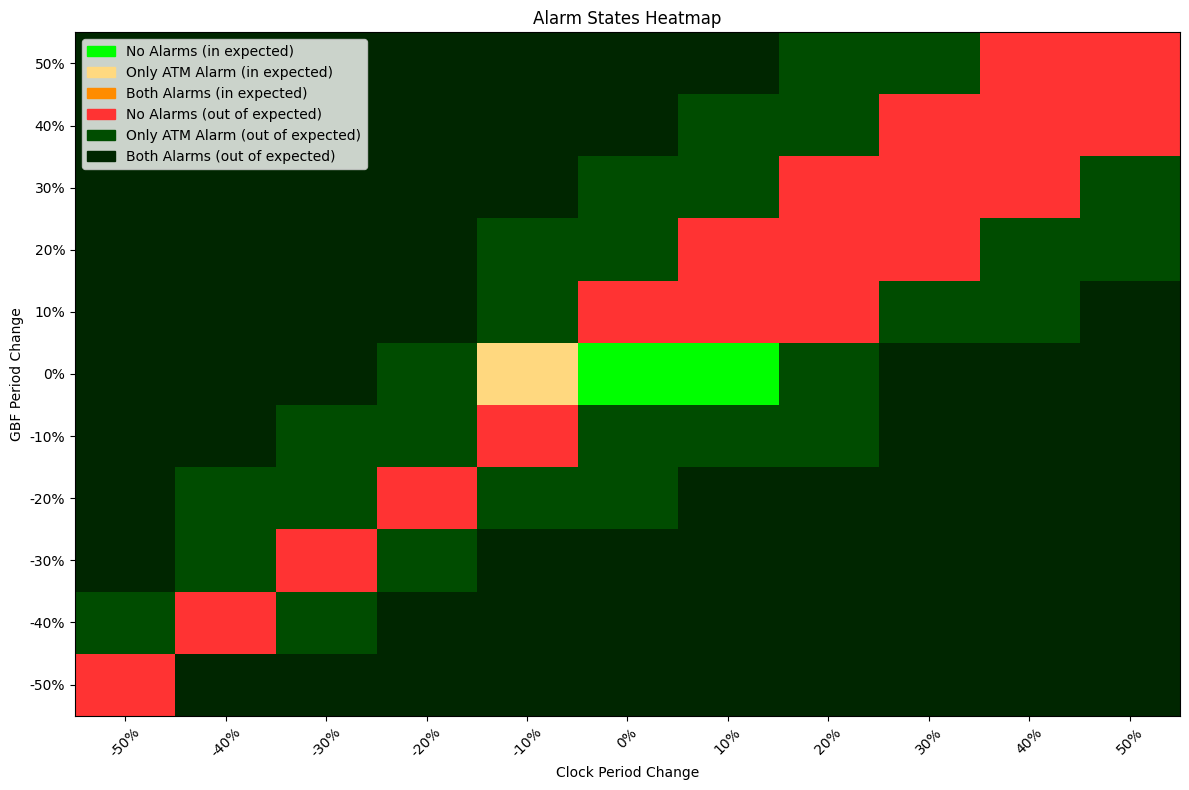

In [74]:
plot_alarm_heatmap("simulation_results_5percent.csv", -50, 50, 10, True, 10, 5)

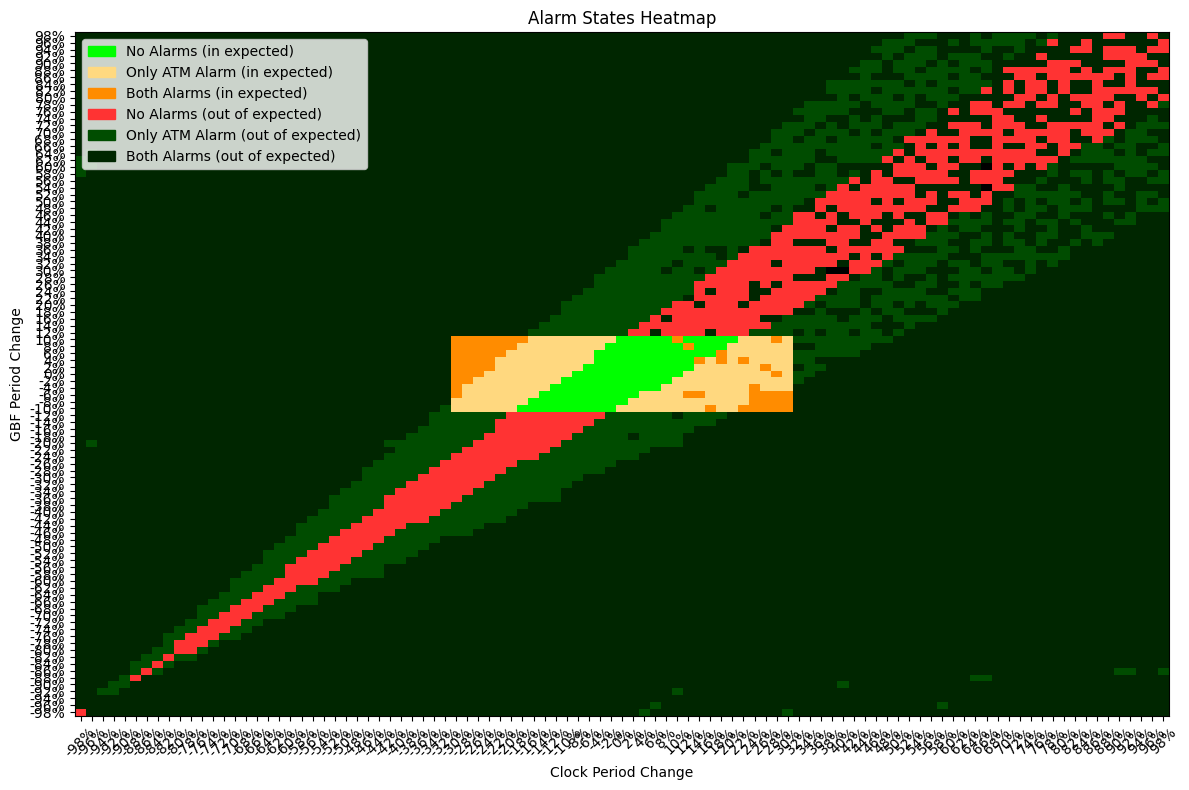

In [75]:
plot_alarm_heatmap("simulation_results_2percent.csv", -98, 98, 2, False, 30, 10)

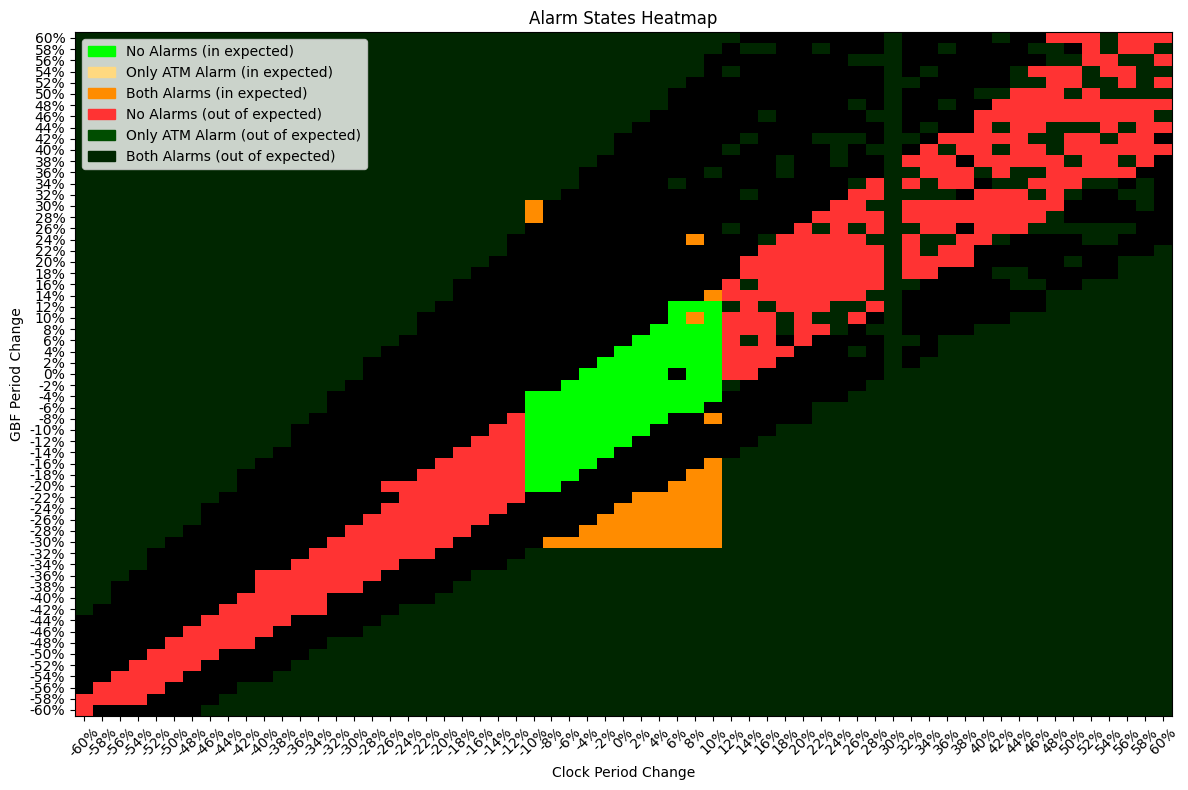

In [76]:
plot_alarm_heatmap("simulation_results_50_2percent.csv", -60, 60, 2, False, 10, 30)

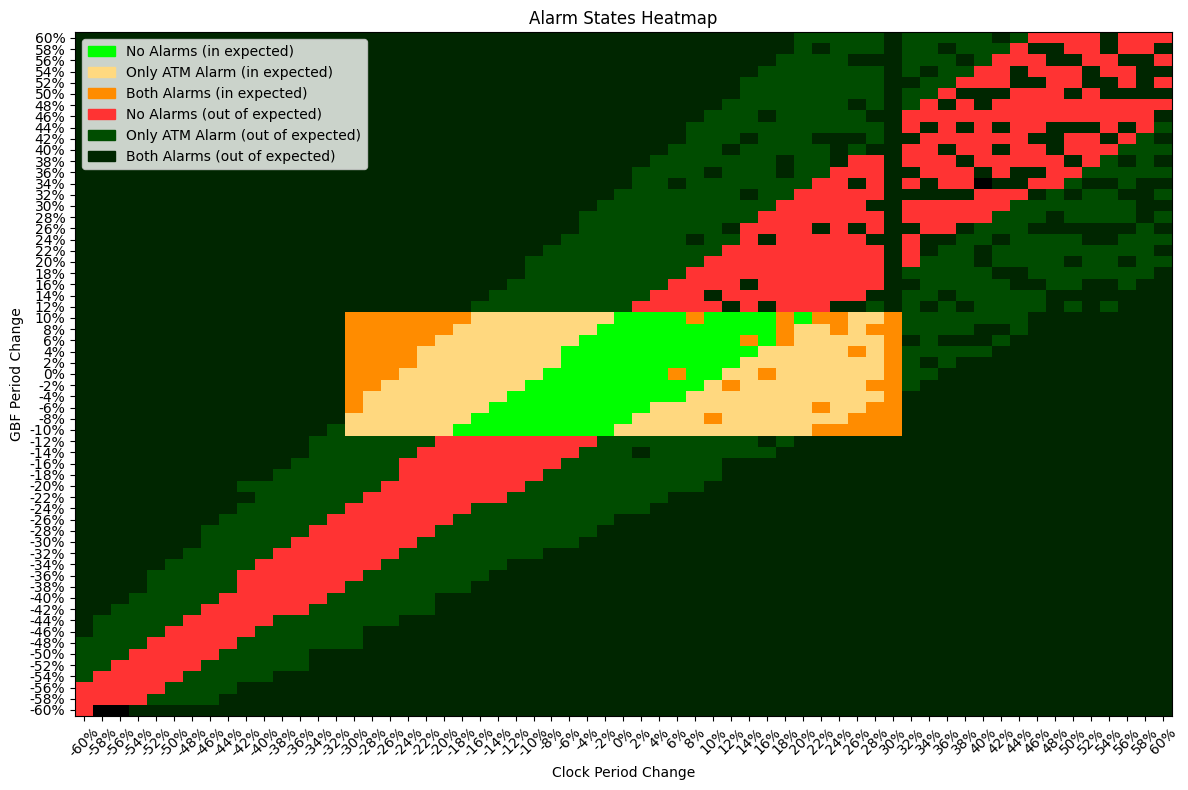

In [77]:
plot_alarm_heatmap("simulation_results_50_2percent_v2.csv", -60, 60, 2, False, 30, 10)

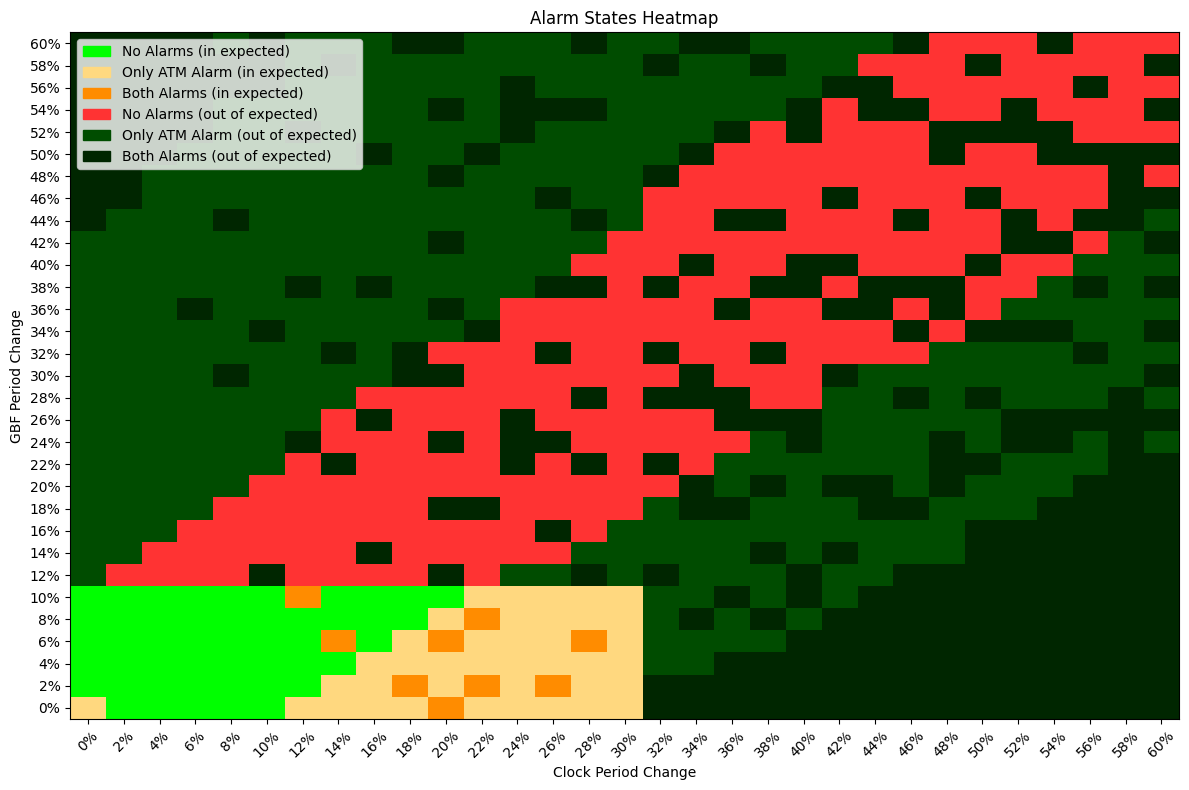

In [78]:
# Tried to solve the issue with faulty alarms in the previous version of the code by adding synchronization of the falling edge detector.
# The issue was that the falling edge detector was not synchronized with the rest of the system.
# Also started to run for only the positive values changes of gbf_T(s) and clk_s_T(s), since the problem only happened in those cases.

plot_alarm_heatmap("simulation_results_50_2percent_v3.csv", 0, 60, 2, False, 30, 10)

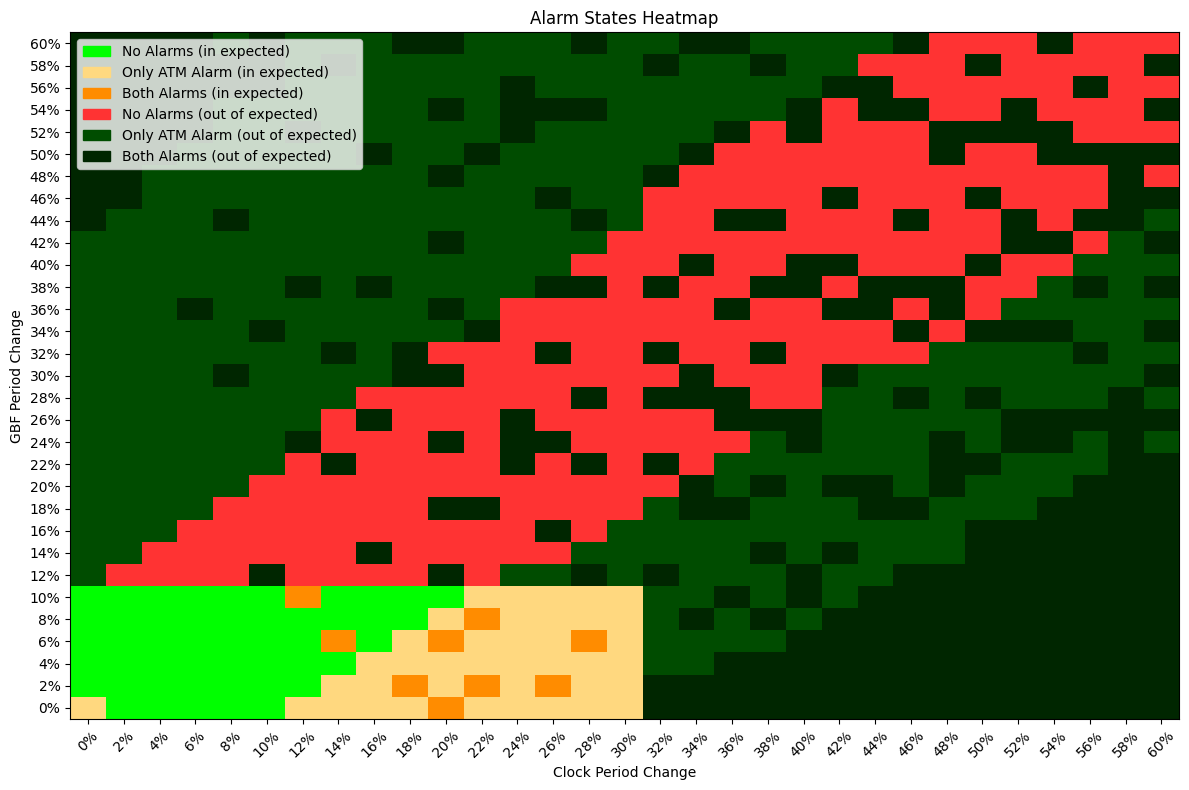

In [79]:
# Tried here to add another step to the synchroniser of Counter Detector

plot_alarm_heatmap("simulation_results_50_2percent_v4.csv", 0, 60, 2, False, 30, 10)

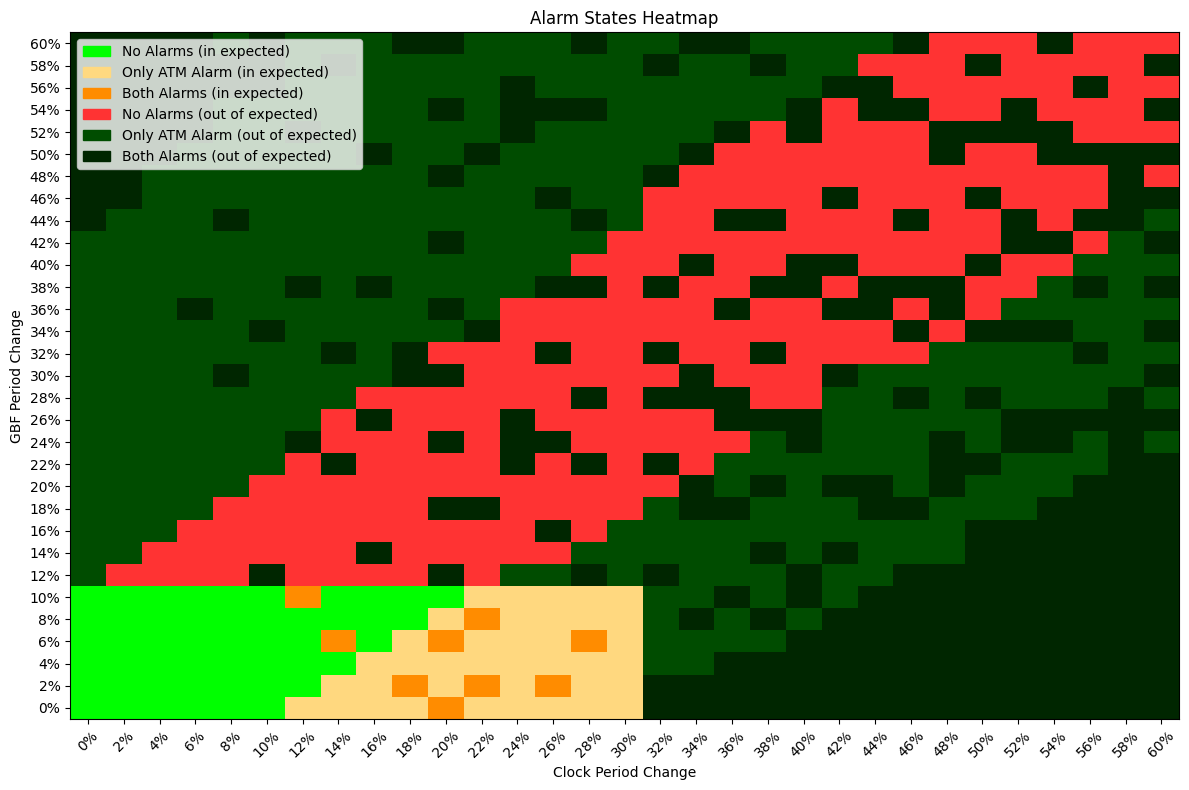

In [80]:
# Tried to add another step to the synchroniser of the Falling Edge Detector

plot_alarm_heatmap("simulation_results_50_2percent_v5.csv", 0, 60, 2, False, 30, 10)

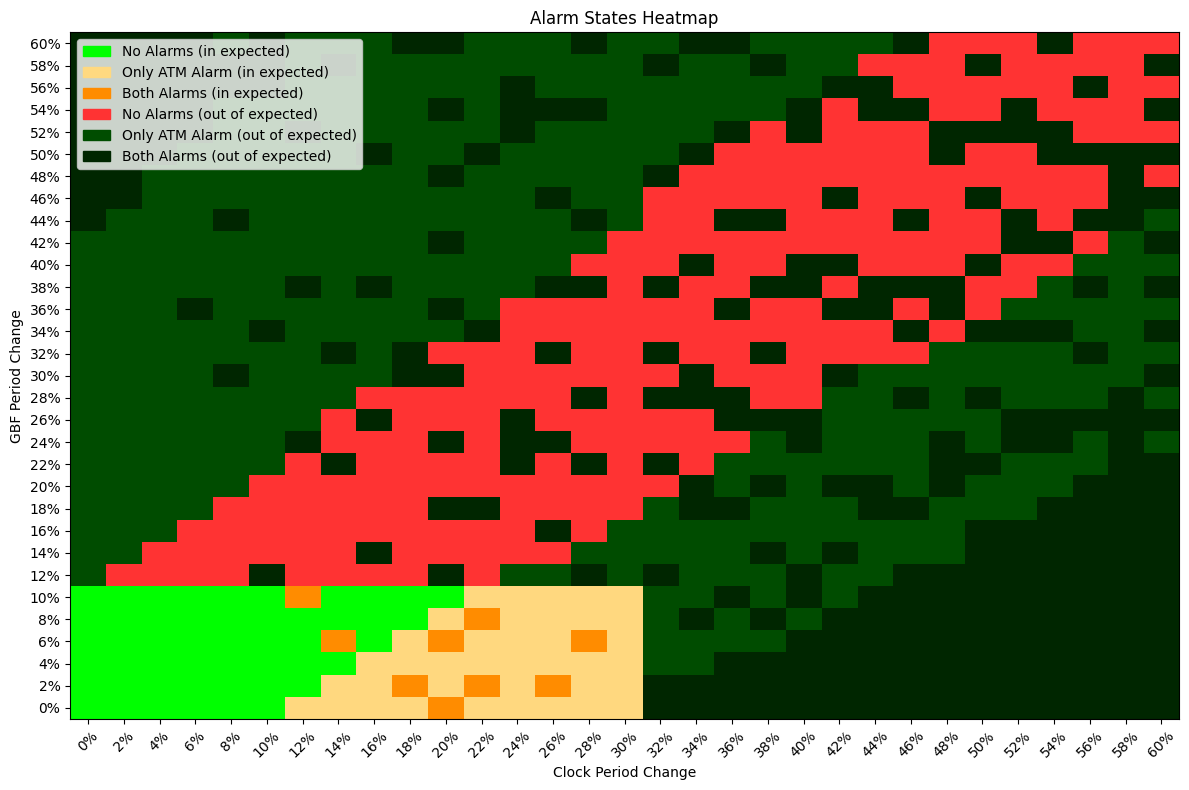

In [81]:
# Tried to add another step to the synchroniser of the Falling Edge Detector

plot_alarm_heatmap("simulation_results_50_2percent_v6.csv", 0, 60, 2, False, 30, 10)

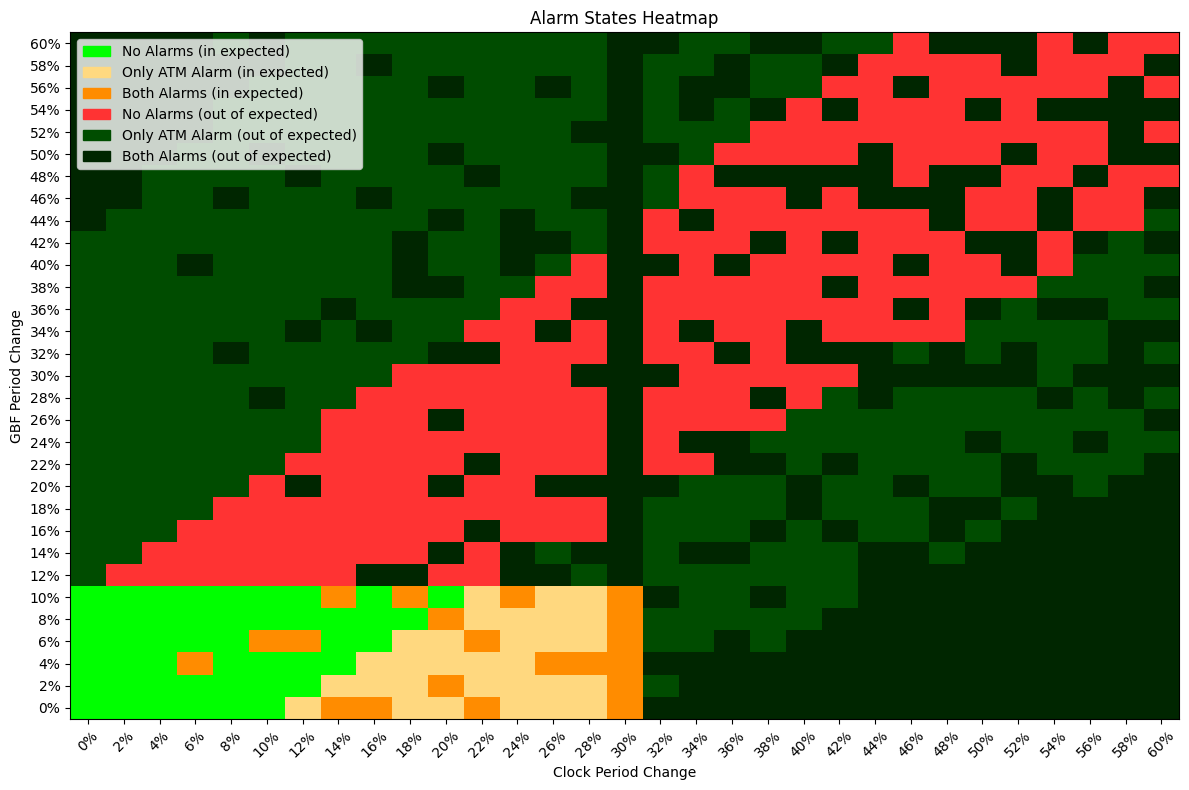

In [82]:
# Changed the reset logic in the simulation to be more accurate

plot_alarm_heatmap("simulation_results_50_2percent_v7.csv", 0, 60, 2, False, 30, 10)

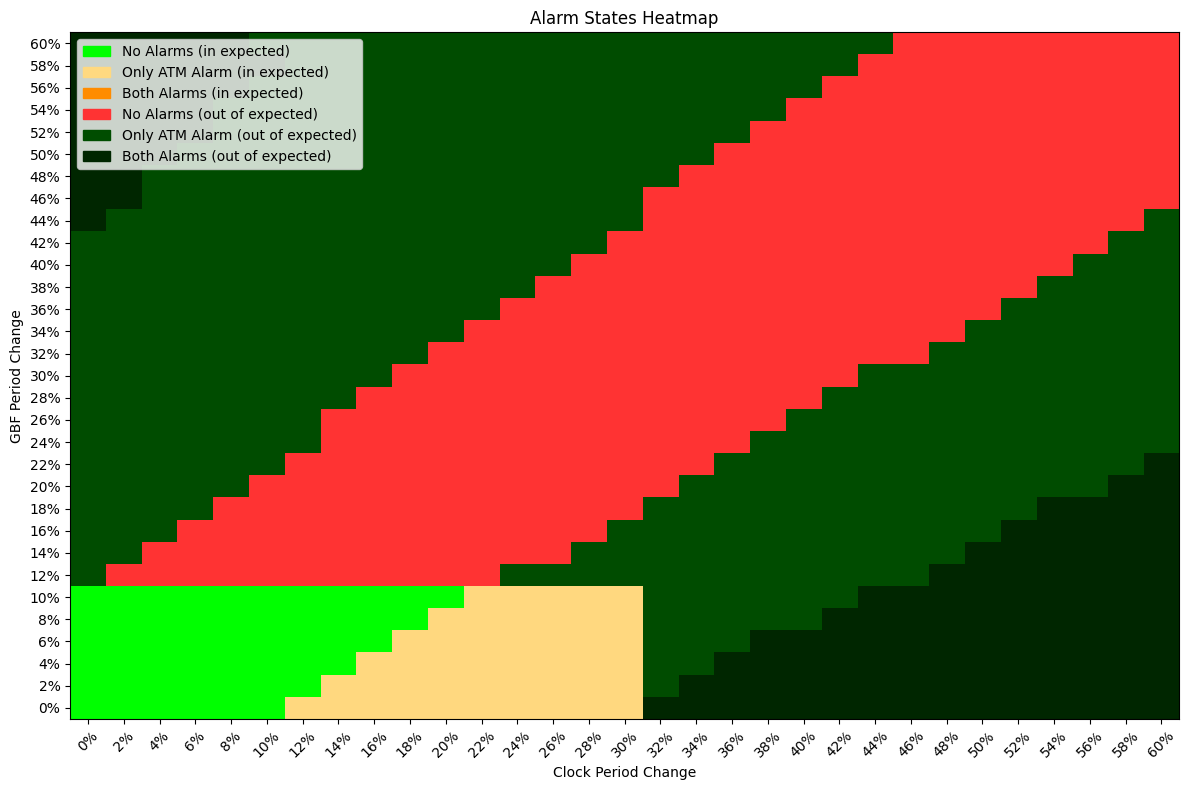

In [83]:
# Changed reset again to be dynamic instead of static since it could sometimes cause null values in the simulation (dark squares)

plot_alarm_heatmap("simulation_results_50_2percent_v8.csv", 0, 60, 2, False, 30, 10)

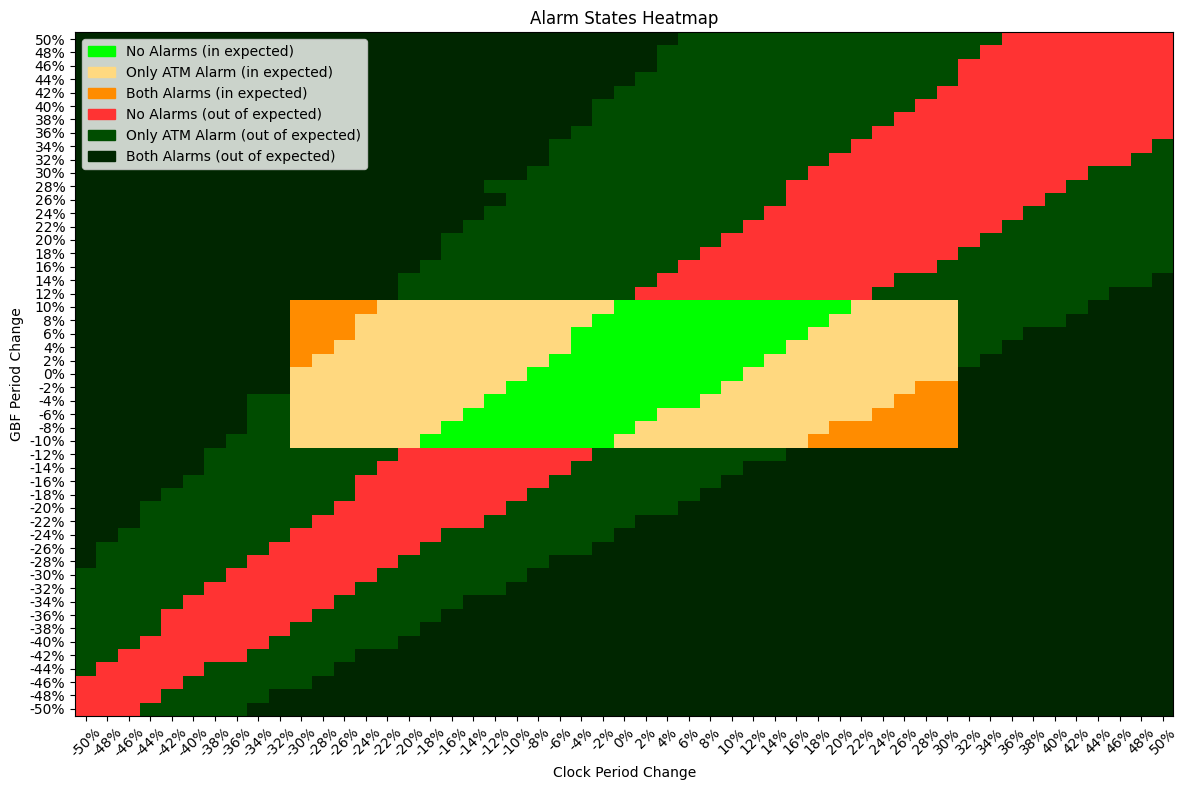

In [84]:
# Plotting the alarm heatmap using frequencies changes instead of periods changes. 
# Latest version, and the one which seems to have the best results.

plot_alarm_heatmap("simulation_results_50_2percent_v9.csv", -50, 50, 2, False, 30, 10)

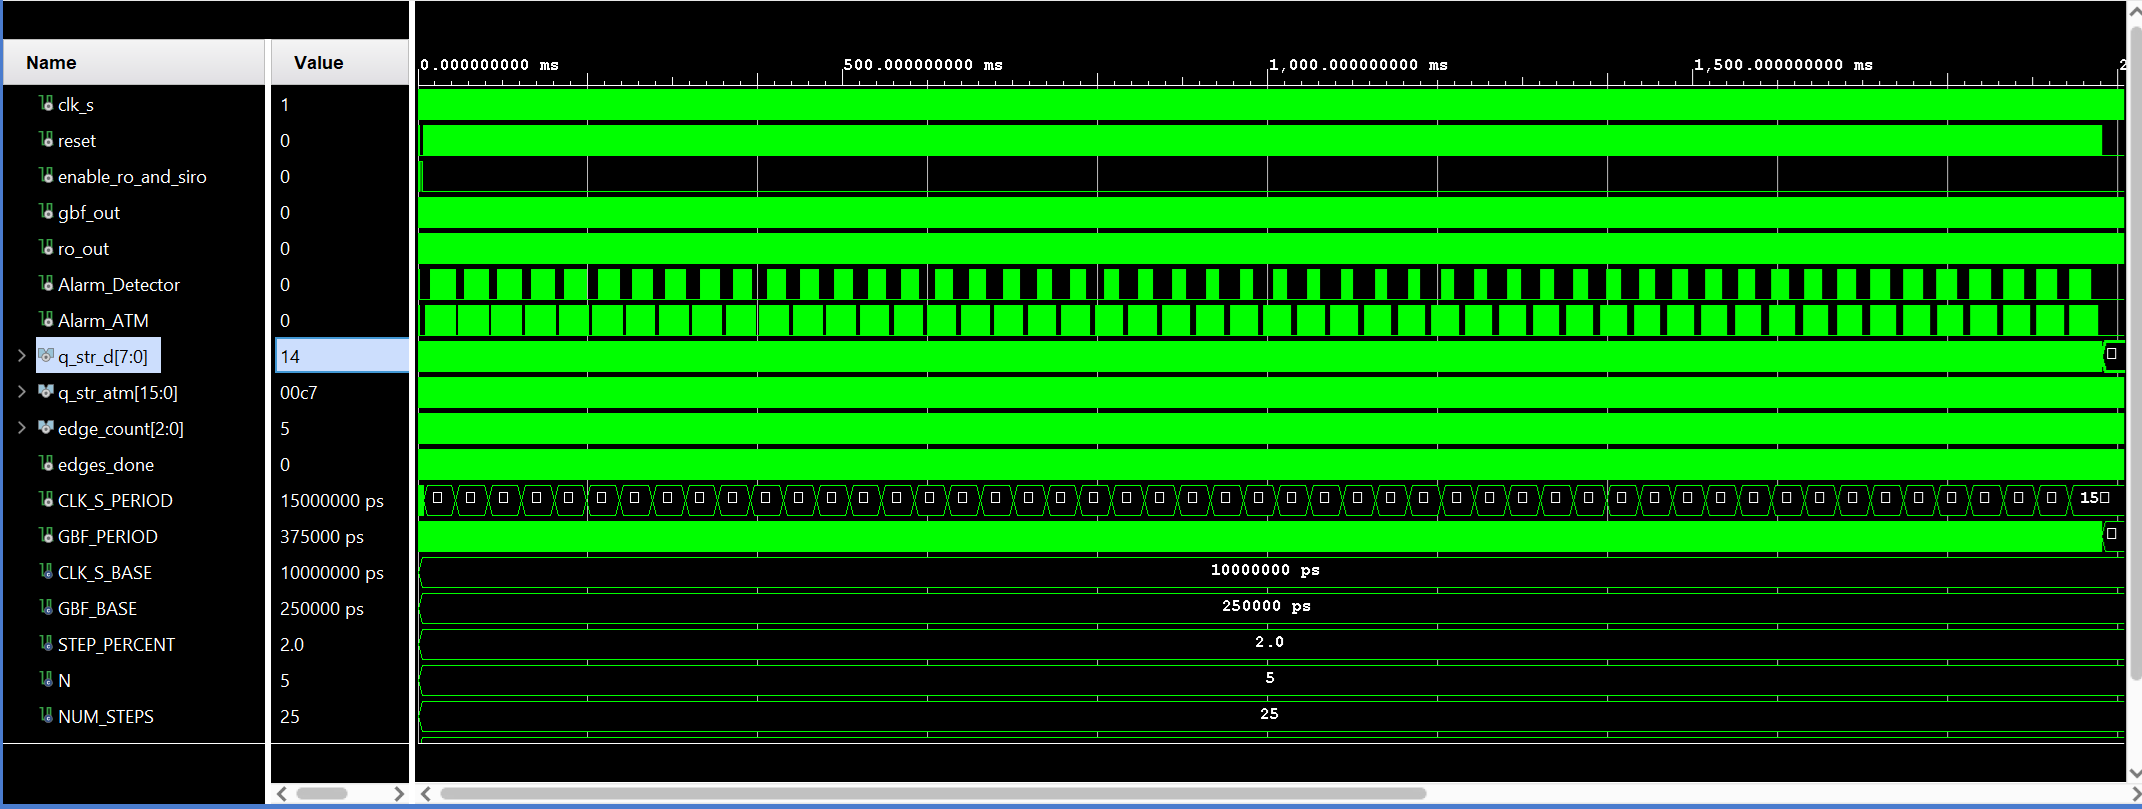

In [85]:
from IPython.display import Image, display

display(Image(filename="C:/Users/Des/Desktop/MdR_Latest_Simulation_Results.png"))

# Latest simulations results, used in the heatmap plot above.

In [86]:
# plot_theory_heatmap(0.02, 10e-6, 250e-9, 0.3, 0.1, 20, 200, 25, 11)